In [54]:
# General data handling
import numpy as np
import pandas as pd
import warnings

# Drawing plots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning with scikit-learn
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight
from scipy import stats as ss

Loading both training and scoring datasets into pandas dataframe.

In [2]:
# Paths to the datasets
training_file_path = 'E:\SEM 2\Data_visualization\Assignment_2\RF_TrainingDatasetA_Final-1.xlsx'
scoring_file_path = 'E:\SEM 2\Data_visualization\Assignment_2\RF_ScoringDatasetA_Final-1.xlsx'

# Load the datasets
training_data = pd.read_excel(training_file_path)
scoring_data = pd.read_excel(scoring_file_path)

To level and to standardise the columns of both datasetrts.

In [3]:
# Standardize the column names: lowercase and replace spaces with underscores
training_data.columns = training_data.columns.str.lower().str.replace(" ", "_")
scoring_data.columns = scoring_data.columns.str.lower().str.replace(" ", "_")

# Resolve naming inconsistencies
training_data.rename(columns={'dpq_r2_': 'dpq_r2'}, inplace=True)

Checking for missing values in both datasets.

In [4]:
# Check for missing values
def check_missing_values(df, name):
    missing_values = df.isnull().sum()
    print(f"Missing values in {name}:")
    print(missing_values[missing_values >0])  # Display only columns with missing values

check_missing_values(training_data, "Training Dataset")
check_missing_values(scoring_data, "Scoring Dataset")


Missing values in Training Dataset:
dpq_r2       9
fullmin      6
outcome    105
dtype: int64
Missing values in Scoring Dataset:
Series([], dtype: int64)


Treating missing values.

In [5]:
# Drop rows with any missing values
training_data.dropna(inplace=True)

Validation after treating missing values.

In [6]:
print("\nMissing values after cleanup in Training Dataset:")
print(training_data.isnull().sum().max())  

print("\nMissing values after cleanup in Scoring Dataset:")
print(scoring_data.isnull().sum().max())


Missing values after cleanup in Training Dataset:
0

Missing values after cleanup in Scoring Dataset:
0


Remove irrelavant and redundant columns from the dataset.

In [7]:
# Remove irrelevant columns
irrelevant_columns = ['antennafilename1', 'antennafilename2', 'outcome']
training_data.drop(columns=irrelevant_columns, inplace=True)

To assess and solve the bijection to certain extent for numeric , checking for highly corelated variables and removinng them to reduce redundancy with the help of correlation matrix

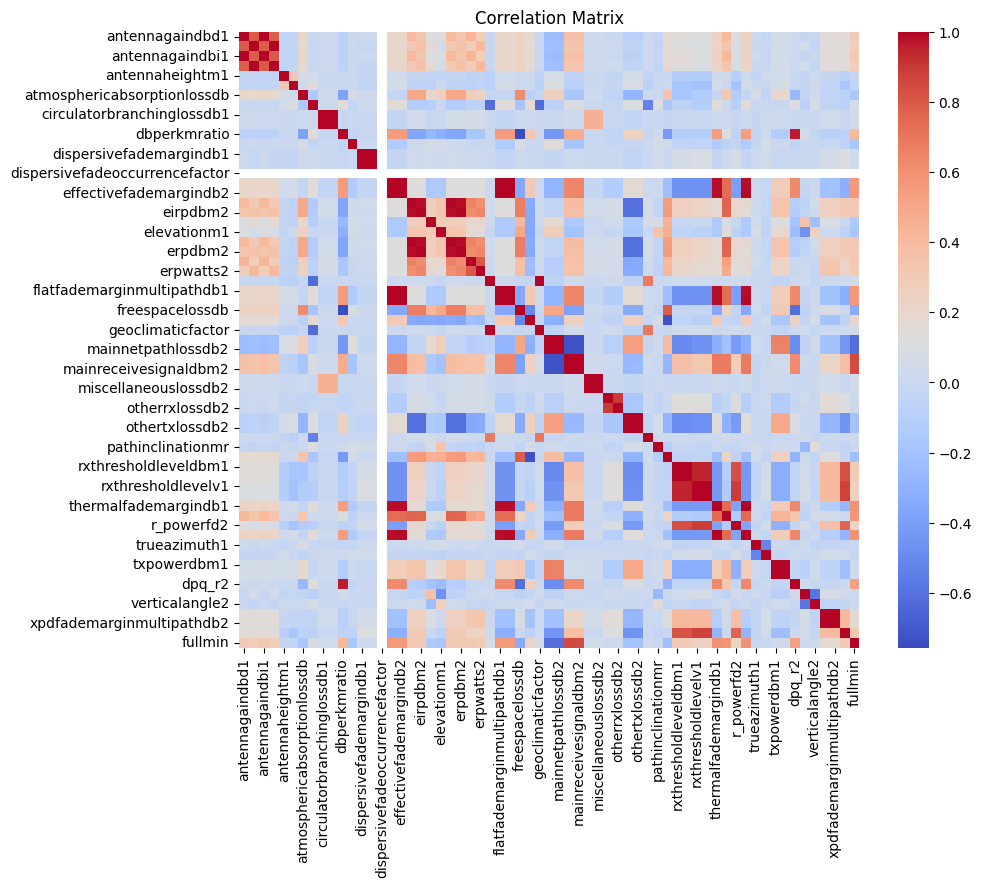

Removed the following highly correlated features: {'flatfademarginmultipathdb2', 'dpq_r2', 'dispersivefademargindb2', 'flatfademarginmultipathdb1', 'rxthresholdlevelv2', 'xpdfademarginmultipathdb2', 'erpdbm2', 'geoclimaticfactor', 'thermalfademargindb2', 'circulatorbranchinglossdb2', 'rxthresholdlevelv1', 'othertxlossdb2', 'mainreceivesignaldbm2', 'effectivefademargindb2', 'mainnetpathlossdb2', 'antennagaindbi1', 'rxthresholdleveldbm2', 'antennagaindbi2', 'thermalfademargindb1', 'txpowerdbm2', 'eirpdbm2', 'erpdbm1', 'miscellaneouslossdb2'}
New dataframe shape: (2068, 53)


In [8]:
# Calculate the correlation matrix
numerical_features = training_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()

# Display the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Identify and remove highly correlated features
high_corr_threshold = 0.90
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= high_corr_threshold:
            high_corr_features.add(correlation_matrix.columns[j])

training_data_reduced = training_data.drop(columns=high_corr_features)
print("Removed the following highly correlated features:", high_corr_features)
print("New dataframe shape:", training_data_reduced.shape)

Function to check for duplicate columns and impute them.

In [9]:
# Find duplicate columns
def identify_duplicate_columns(df):
    duplicates = []
    for i in range(df.shape[1]):
        col1 = df.iloc[:, i]
        for j in range(i + 1, df.shape[1]):
            col2 = df.iloc[:, j]
            if col1.equals(col2):
                duplicates.append((df.columns[i], df.columns[j]))
    return duplicates

duplicate_columns = identify_duplicate_columns(training_data_reduced)
print("Duplicate Columns:")
for dup in duplicate_columns:
    print(f"Column {dup[0]} is a duplicate of Column {dup[1]}")

# Remove specified duplicate columns
columns_to_exclude = ['emissiondesignator2', 'radiofilename2', 'radiomodel2']
training_data_reduced.drop(columns=columns_to_exclude, inplace=True)
print("Updated DataFrame shape:", training_data_reduced.shape)

Duplicate Columns:
Column emissiondesignator1 is a duplicate of Column emissiondesignator2
Column radiofilename1 is a duplicate of Column radiofilename2
Column radiomodel1 is a duplicate of Column radiomodel2
Updated DataFrame shape: (2068, 50)


To assess, solve the bijection to certain extent for float variables , checking for highly corelated variables and removinng them to reduce redundancy with the help of correlation matrix

Correlation matrix for float columns:
                             antennagaindbd1  antennagaindbd2  \
antennagaindbd1                     1.000000         0.794275   
antennagaindbd2                     0.794275         1.000000   
antennaheightm1                    -0.039493        -0.047597   
antennaheightm2                    -0.053225        -0.038915   
atmosphericabsorptionlossdb         0.217441         0.185970   
averageannualtemperaturec          -0.001306        -0.008823   
circulatorbranchinglossdb1          0.005607         0.008047   
dbperkmratio                       -0.082230        -0.074562   
diffractionlossdb                   0.001129         0.008235   
dispersivefademargindb1             0.012179        -0.023924   
effectivefademargindb1              0.213831         0.201125   
eirpdbm1                            0.398283         0.308081   
elevation2                          0.113084         0.169376   
elevationm1                         0.112738        

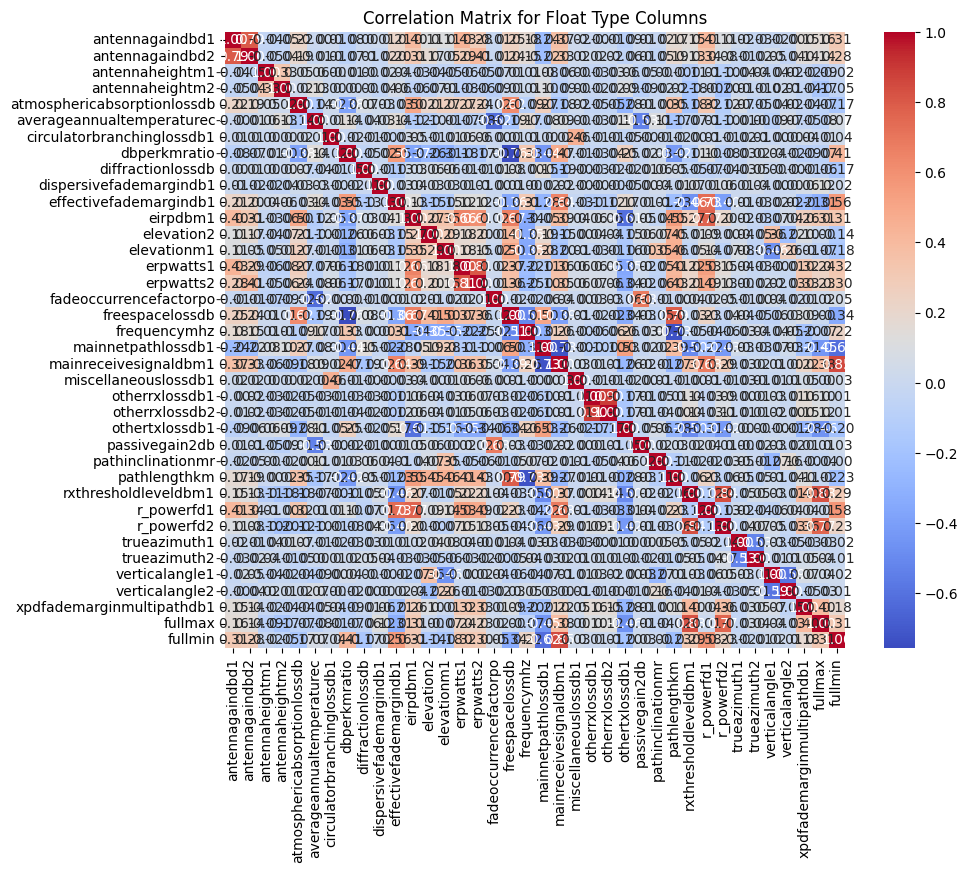

Removed columns due to high correlation: {'otherrxlossdb2'}
Updated DataFrame shape: (2068, 49)


In [10]:
# Compute the correlation matrix for float columns
float_columns = training_data_reduced.select_dtypes(include=['float64'])
float_corr_matrix = float_columns.corr()

print("Correlation matrix for float columns:")
print(float_corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(float_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Float Type Columns')
plt.show()

# Identify and drop highly correlated float features
float_corr_threshold = 0.85
float_corr_features_to_drop = set()

for i in range(len(float_corr_matrix.columns)):
    for j in range(i + 1, len(float_corr_matrix.columns)):
        if abs(float_corr_matrix.iloc[i, j]) > float_corr_threshold:
            float_corr_features_to_drop.add(float_corr_matrix.columns[j])

training_data_reduced.drop(columns=list(float_corr_features_to_drop), inplace=True)
print(f"Removed columns due to high correlation: {float_corr_features_to_drop}")
print(f"Updated DataFrame shape: {training_data_reduced.shape}")

checking for correlation of categorical variables using Cramer's V calculation

In [11]:
# Cramer's V calculation for categorical features
def calculate_cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

categorical_columns = training_data_reduced.select_dtypes(include=['object']).columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cramers_v_matrix.at[col1, col2] = calculate_cramers_v(training_data_reduced[col1], training_data_reduced[col2])

print(cramers_v_matrix)

C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: inv

                     rfdbid eng_class antennamodel1 antennamodel2  \
rfdbid                  NaN       NaN           NaN           NaN   
eng_class               NaN       NaN      0.083641      0.157245   
antennamodel1           inf  0.083641           NaN      0.880789   
antennamodel2           inf  0.157245      0.880789           NaN   
emissiondesignator1     inf  0.202715      0.462557      0.459902   
polarization            inf  0.034723      0.248803      0.230558   
radiofilename1          inf  0.469229      0.473235      0.472235   
radiomodel1             NaN  0.476921      0.497446      0.486895   
rxthresholdcriteria1    NaN  0.233612      0.632887      0.630555   
rxthresholdcriteria2    NaN  0.164137      0.437519      0.436202   

                     emissiondesignator1 polarization radiofilename1  \
rfdbid                               NaN          NaN            NaN   
eng_class                       0.202715     0.034723       0.469229   
antennamodel1           

C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_1232\1563184515.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))


Dropping highly correlated categorical variables.

In [12]:
# Drop highly correlated categorical features
cat_corr_threshold = 0.88
cat_features_to_drop = set()

for col1 in cramers_v_matrix.columns:
    for col2 in cramers_v_matrix.index:
        if (col1 != col2 and cramers_v_matrix.at[col1, col2] > cat_corr_threshold):
            cat_features_to_drop.add(col1)

training_data_reduced.drop(columns=list(cat_features_to_drop), inplace=True)
print(f"Columns dropped due to high correlation: {cat_features_to_drop}")
print(f"Updated DataFrame shape: {training_data_reduced.shape}")

Columns dropped due to high correlation: {'antennamodel2', 'antennamodel1', 'radiomodel1', 'polarization', 'rxthresholdcriteria1', 'emissiondesignator1', 'rxthresholdcriteria2', 'radiofilename1', 'rfdbid'}
Updated DataFrame shape: (2068, 40)


leveling the columns between training and scoring datasets.

In [13]:
# Align columns between training and scoring datasets
training_features = set(training_data_reduced.columns) - {'eng_class'}
scoring_features = set(scoring_data.columns)
extra_scoring_features = scoring_features - training_features

scoring_data_aligned = scoring_data.drop(columns=list(extra_scoring_features))
print("Updated columns in scoring data:", scoring_data_aligned.columns)


Updated columns in scoring data: Index(['antennagaindbd1', 'antennagaindbd2', 'antennaheightm1',
       'antennaheightm2', 'atmosphericabsorptionlossdb',
       'averageannualtemperaturec', 'circulatorbranchinglossdb1',
       'dbperkmratio', 'diffractionlossdb', 'dispersivefademargindb1',
       'dispersivefadeoccurrencefactor', 'effectivefademargindb1', 'eirpdbm1',
       'elevation2', 'elevationm1', 'erpwatts1', 'erpwatts2',
       'fadeoccurrencefactorpo', 'freespacelossdb', 'frequencymhz',
       'mainnetpathlossdb1', 'mainreceivesignaldbm1', 'miscellaneouslossdb1',
       'otherrxlossdb1', 'othertxlossdb1', 'passivegain2db',
       'pathinclinationmr', 'pathlengthkm', 'rxthresholdleveldbm1',
       'trueazimuth1', 'trueazimuth2', 'txpowerdbm1', 'r_powerfd1',
       'r_powerfd2', 'verticalangle1', 'verticalangle2',
       'xpdfademarginmultipathdb1', 'fullmax', 'fullmin'],
      dtype='object')


In [14]:
# Align columns between training and scoring datasets again after further feature reduction
training_features_final = set(training_data_reduced.columns) - {'eng_class'}
scoring_features_final = set(scoring_data_aligned.columns)
extra_scoring_features_final = scoring_features_final - training_features_final

scoring_data_aligned_final = scoring_data_aligned.drop(columns=list(extra_scoring_features_final))
print("Final columns in scoring data:", scoring_data_aligned_final.columns)
print("Final shape of scoring data:", scoring_data_aligned_final.shape)

Final columns in scoring data: Index(['antennagaindbd1', 'antennagaindbd2', 'antennaheightm1',
       'antennaheightm2', 'atmosphericabsorptionlossdb',
       'averageannualtemperaturec', 'circulatorbranchinglossdb1',
       'dbperkmratio', 'diffractionlossdb', 'dispersivefademargindb1',
       'dispersivefadeoccurrencefactor', 'effectivefademargindb1', 'eirpdbm1',
       'elevation2', 'elevationm1', 'erpwatts1', 'erpwatts2',
       'fadeoccurrencefactorpo', 'freespacelossdb', 'frequencymhz',
       'mainnetpathlossdb1', 'mainreceivesignaldbm1', 'miscellaneouslossdb1',
       'otherrxlossdb1', 'othertxlossdb1', 'passivegain2db',
       'pathinclinationmr', 'pathlengthkm', 'rxthresholdleveldbm1',
       'trueazimuth1', 'trueazimuth2', 'txpowerdbm1', 'r_powerfd1',
       'r_powerfd2', 'verticalangle1', 'verticalangle2',
       'xpdfademarginmultipathdb1', 'fullmax', 'fullmin'],
      dtype='object')
Final shape of scoring data: (936, 39)


In [15]:
training_data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2068 entries, 0 to 2080
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   eng_class                       2068 non-null   object 
 1   antennagaindbd1                 2068 non-null   float64
 2   antennagaindbd2                 2068 non-null   float64
 3   antennaheightm1                 2068 non-null   float64
 4   antennaheightm2                 2068 non-null   float64
 5   atmosphericabsorptionlossdb     2068 non-null   float64
 6   averageannualtemperaturec       2068 non-null   float64
 7   circulatorbranchinglossdb1      2068 non-null   float64
 8   dbperkmratio                    2068 non-null   float64
 9   diffractionlossdb               2068 non-null   float64
 10  dispersivefademargindb1         2068 non-null   float64
 11  dispersivefadeoccurrencefactor  2068 non-null   int64  
 12  effectivefademargindb1          2068 no

In [16]:
scoring_data_aligned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   antennagaindbd1                 936 non-null    float64
 1   antennagaindbd2                 936 non-null    float64
 2   antennaheightm1                 936 non-null    float64
 3   antennaheightm2                 936 non-null    float64
 4   atmosphericabsorptionlossdb     936 non-null    float64
 5   averageannualtemperaturec       936 non-null    float64
 6   circulatorbranchinglossdb1      936 non-null    float64
 7   dbperkmratio                    936 non-null    float64
 8   diffractionlossdb               936 non-null    float64
 9   dispersivefademargindb1         936 non-null    float64
 10  dispersivefadeoccurrencefactor  936 non-null    int64  
 11  effectivefademargindb1          936 non-null    float64
 12  eirpdbm1                        936 

Handling categorical variables usinng Label encoder.

In [17]:
# Encode categorical columns
def encode_categorical_columns(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        if df[column].nunique() < 50:
            df[column] = df[column].astype(str)
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le
    return df, label_encoders

In [18]:
# Apply the label encoding function to the training data
training_data_encoded, training_encoders = encode_categorical_columns(training_data_reduced)

In [19]:
# Apply the label encoding function to the scoring data using the same encoders
for column, le in training_encoders.items():
    if column in scoring_data_aligned.columns:
        scoring_data_aligned[column] = le.transform(scoring_data_aligned[column].astype(str))


In [20]:
# Checking the changes and types to confirm
print(training_data_encoded.head())
print(training_data_encoded.dtypes)
print(scoring_data_aligned.head())
print(scoring_data_aligned.dtypes)

   eng_class  antennagaindbd1  antennagaindbd2  antennaheightm1  \
0          1             39.9             39.9             30.0   
1          1             33.7             33.7             30.0   
2          1             33.7             33.7             30.0   
3          2             33.7             39.9             30.0   
4          1             33.7             33.7             30.0   

   antennaheightm2  atmosphericabsorptionlossdb  averageannualtemperaturec  \
0             60.0                          0.6                        8.6   
1             30.0                          0.3                        9.0   
2             30.0                          0.3                        9.5   
3             30.0                          0.6                        9.9   
4             30.0                          0.3                        9.2   

   circulatorbranchinglossdb1  dbperkmratio  diffractionlossdb  ...  \
0                         0.0           1.1              

Checking for any zero value rows before splitting the data.

In [21]:
column_name = 'eng_class' 
zero_counts = (training_data_encoded[column_name] == 0).sum()

In [22]:
print(zero_counts)

3


Treating the zero value rows.

In [23]:
non_zero_index = training_data_encoded['eng_class'] != 0
training_data_encoded = training_data_encoded[non_zero_index]

In [24]:
column_name = 'eng_class' 
zero_counts = (training_data_encoded[column_name] == 0).sum()

In [25]:
print(zero_counts)

0


To prepare the feature and target data for spliting.

In [26]:
# Prepare features and target again with the fully encoded dataset
X = training_data_encoded.drop(['eng_class'], axis=1)  # Exclude non-numeric and identifier columns
y = training_data_encoded['eng_class']

Display the feature data X

In [27]:
# Display the first few rows of Y to verify
print("Shape of the DataFrame:", X.shape)
print("Descriptive Features (X):")
# View the first few rows of the DataFrame
pd.set_option('display.max_rows', 5)

# Increase the number of max columns to None (or a fixed number if the dataset is too wide)
pd.set_option('display.max_columns', None)

# Set up the Jupyter Notebook display for horizontal scrolling
pd.set_option('display.expand_frame_repr', False)
print("First few rows:")
display(X.head())


# View the last few rows of the DataFrame
pd.set_option('display.max_rows', 5)

# Increase the number of max columns to None (or a fixed number if the dataset is too wide)
pd.set_option('display.max_columns', None)

# Set up the Jupyter Notebook display for horizontal scrolling
pd.set_option('display.expand_frame_repr', False)
print("Last few rows:")
display(X.tail())

Shape of the DataFrame: (2065, 39)
Descriptive Features (X):
First few rows:


,antennagaindbd1,antennagaindbd2,antennaheightm1,antennaheightm2,atmosphericabsorptionlossdb,averageannualtemperaturec,circulatorbranchinglossdb1,dbperkmratio,diffractionlossdb,dispersivefademargindb1,dispersivefadeoccurrencefactor,effectivefademargindb1,eirpdbm1,elevation2,elevationm1,erpwatts1,erpwatts2,fadeoccurrencefactorpo,freespacelossdb,frequencymhz,mainnetpathlossdb1,mainreceivesignaldbm1,miscellaneouslossdb1,otherrxlossdb1,othertxlossdb1,passivegain2db,pathinclinationmr,pathlengthkm,rxthresholdleveldbm1,r_powerfd1,r_powerfd2,trueazimuth1,trueazimuth2,txpowerdbm1,verticalangle1,verticalangle2,xpdfademarginmultipathdb1,fullmax,fullmin
0,39.9,39.9,30.0,60.0,0.6,8.6,0.0,1.1,0.0,0.0,1,34.3,58.5,290.3,285.5,708.0,708.0,0.1,144.6,13094.0,62.7,-44.7,0.0,0.0,1.5,0.0,1.1,30.9,-79.0,92.8,27.6,312.1,131.8,18,0.0,-0.2,0.0,165.531,-140.6
1,33.7,33.7,30.0,30.0,0.3,9.0,0.0,2.3,0.0,0.0,1,28.8,50.9,17.8,290.0,123.0,123.0,0.0,136.7,13038.0,75.3,-50.3,0.0,0.0,9.9,0.0,21.8,12.5,-79.0,79.7,50.2,262.5,82.4,25,-1.3,1.2,0.0,107.250,-173.4
2,33.7,33.7,30.0,30.0,0.3,9.5,0.0,2.1,0.0,0.0,1,28.2,50.9,283.5,373.5,123.0,123.0,0.0,137.2,12898.0,75.8,-50.8,0.0,0.0,9.9,0.0,6.7,13.4,-79.0,79.1,27.6,202.4,22.3,25,-0.4,0.3,0.0,106.740,-190.7
3,33.7,39.9,30.0,30.0,0.6,9.9,0.0,1.1,0.0,0.0,1,31.3,58.8,413.1,27.1,758.6,1288.3,0.0,144.0,12898.0,72.7,-47.7,0.0,0.0,2.0,0.0,13.2,29.2,-79.0,90.1,27.6,232.8,52.5,25,0.7,-0.9,0.0,117.740,-149.8
4,33.7,33.7,30.0,30.0,0.3,9.2,0.0,1.8,0.0,0.0,1,27.1,50.9,40.0,89.7,123.0,123.0,0.0,138.3,12898.0,76.9,-51.9,0.0,0.0,9.9,0.0,3.3,15.1,-79.0,78.0,72.8,49.3,229.4,25,-0.2,0.1,0.0,105.620,-201.3


Last few rows:


,antennagaindbd1,antennagaindbd2,antennaheightm1,antennaheightm2,atmosphericabsorptionlossdb,averageannualtemperaturec,circulatorbranchinglossdb1,dbperkmratio,diffractionlossdb,dispersivefademargindb1,dispersivefadeoccurrencefactor,effectivefademargindb1,eirpdbm1,elevation2,elevationm1,erpwatts1,erpwatts2,fadeoccurrencefactorpo,freespacelossdb,frequencymhz,mainnetpathlossdb1,mainreceivesignaldbm1,miscellaneouslossdb1,otherrxlossdb1,othertxlossdb1,passivegain2db,pathinclinationmr,pathlengthkm,rxthresholdleveldbm1,r_powerfd1,r_powerfd2,trueazimuth1,trueazimuth2,txpowerdbm1,verticalangle1,verticalangle2,xpdfademarginmultipathdb1,fullmax,fullmin
2076,38.0,38.0,30.0,30.0,0.2,9.6,0.0,15.3,0.0,0.0,1,25.1,33.5,59.0,67.5,2.2,2.2,0.0,128.3,37947.0,71.9,-54.9,0.0,0.0,23.6,0.0,5.2,1.6,-80.0,58.6,24.6,271.4,91.4,17,-0.3,0.3,0.0,83.18,-172.6
2077,38.0,38.0,30.0,30.0,0.2,10.0,0.0,15.6,0.0,0.0,1,23.5,31.1,112.2,27.7,1.3,1.3,0.0,127.6,37905.0,73.5,-56.5,0.0,0.0,26.0,0.0,56.3,1.5,-80.0,54.6,44.7,253.7,73.7,17,3.2,-3.2,0.0,119.40,-177.7
2078,38.0,38.0,30.0,30.0,0.3,9.1,0.0,12.1,0.0,0.0,1,25.5,36.1,9.5,8.0,4.1,4.1,0.0,130.5,37947.0,71.5,-54.5,0.0,0.0,21.0,0.0,0.7,2.1,-80.0,61.6,24.6,44.9,224.9,17,0.0,-0.1,0.0,106.29,-171.4
2079,38.0,38.0,30.0,30.0,0.2,9.5,0.0,9.2,7.2,0.0,1,17.3,34.1,439.9,366.0,2.6,2.6,0.0,129.5,37919.0,79.7,-62.7,0.0,0.0,23.0,0.0,39.4,1.9,-80.0,51.4,44.7,55.6,235.6,17,2.3,-2.3,0.0,116.20,-243.4
2080,38.0,38.0,30.0,30.0,0.2,9.7,0.0,16.6,0.0,0.0,1,26.1,37.1,7.0,69.5,5.1,5.1,0.0,128.0,37926.0,67.9,-50.9,0.0,0.0,20.0,0.0,39.9,1.6,-77.0,63.2,63.2,94.9,275.0,17,-2.3,2.3,0.0,97.91,-175.7


Display the target variable y

In [28]:
# Display the first few rows of Y to verify
print("Shape of the DataFrame:", y.shape)
print("Descriptive Features (Y):")
# View the first few rows of the DataFrame
pd.set_option('display.max_rows', 5)

# Increase the number of max columns to None (or a fixed number if the dataset is too wide)
pd.set_option('display.max_columns', None)

# Set up the Jupyter Notebook display for horizontal scrolling
pd.set_option('display.expand_frame_repr', False)
print("First few rows:")
display(y.head())


# View the last few rows of the DataFrame
pd.set_option('display.max_rows', 5)

# Increase the number of max columns to None (or a fixed number if the dataset is too wide)
pd.set_option('display.max_columns', None)

# Set up the Jupyter Notebook display for horizontal scrolling
pd.set_option('display.expand_frame_repr', False)
print("Last few rows:")
display(y.tail())

Shape of the DataFrame: (2065,)
Descriptive Features (Y):
First few rows:


0    1
1    1
2    1
3    2
4    1
Name: eng_class, dtype: int32

Last few rows:


2076    1
2077    1
2078    1
2079    2
2080    1
Name: eng_class, dtype: int32

To split data into train and test, with feature X and target y

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=672)

Checking the length of both feature and target data.

In [30]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))

Length of X_train: 1652
Length of y_train: 1652


fitting a random forest model for the data

In [32]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
rfpred = rf.predict(X_test)

print(classification_report(y_test,rfpred))
print("Accuracy of Random Forest is: ",accuracy_score(y_test,rfpred)*100)

              precision    recall  f1-score   support

           1       0.86      0.96      0.91       321
           2       0.78      0.47      0.59        92

    accuracy                           0.85       413
   macro avg       0.82      0.72      0.75       413
weighted avg       0.85      0.85      0.84       413

Accuracy of Random Forest is:  85.23002421307507


fitting the logistic regression for the data.

In [33]:
# Initialize logistic regression with increased max_iter and different solver
log_reg = LogisticRegression(max_iter=1000, solver='saga')  # 'saga' solver supports more types of penalties and scales well

# Fit the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.98      0.87       321
           2       0.53      0.09      0.15        92

    accuracy                           0.78       413
   macro avg       0.66      0.53      0.51       413
weighted avg       0.73      0.78      0.71       413



C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fiting the Gradient Boosting Classifier model for the data.

In [34]:
# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=672)

# Train the model on the training data
gb_clf.fit(X_train, y_train)
# Make predictions
y_pred = gb_clf.predict(X_test)

# Print accuracy and classification report to evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8571428571428571
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.98      0.91       321
           2       0.84      0.45      0.58        92

    accuracy                           0.86       413
   macro avg       0.85      0.71      0.75       413
weighted avg       0.85      0.86      0.84       413



In [40]:
results = {
    'Model': ['Random Forest', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [0.8513002421307507, 0.78, 0.8521428571428571],
    'Precision (Class 1)': [0.87, 0.79, 0.86],
    'Recall (Class 1)': [0.96, 0.98, 0.98],
    'F1 Score (Class 1)': [0.91, 0.87, 0.91],
    'Precision (Class 2)': [0.78, 0.53, 0.84],
    'Recall (Class 2)': [0.50, 0.09, 0.45],
    'F1 Score (Class 2)': [0.61, 0.15, 0.58]
}

plotting graph to compare the performance of above 3 models.

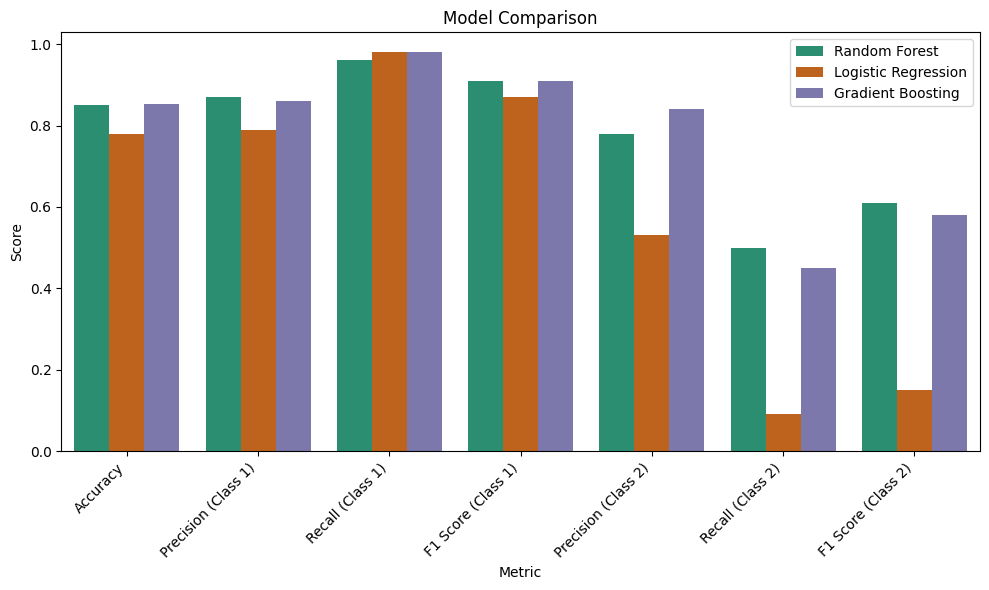

In [50]:
# Creating a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Melting the DataFrame for easier plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

palette = sns.color_palette("Dark2", 3)
# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=results_melted, palette=palette)
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Hyper-parameter tuning for the gradient model.

In [36]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Train the model with the best parameters
best_gb_clf = GradientBoostingClassifier(**best_params, random_state=42)
best_gb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_gb_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score: 0.8607690195001373
Accuracy: 0.8523002421307506
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.99      0.91       321
           2       0.92      0.37      0.53        92

    accuracy                           0.85       413
   macro avg       0.88      0.68      0.72       413
weighted avg       0.86      0.85      0.83       413



Performing the feature selection for the Gradient Boosting model.

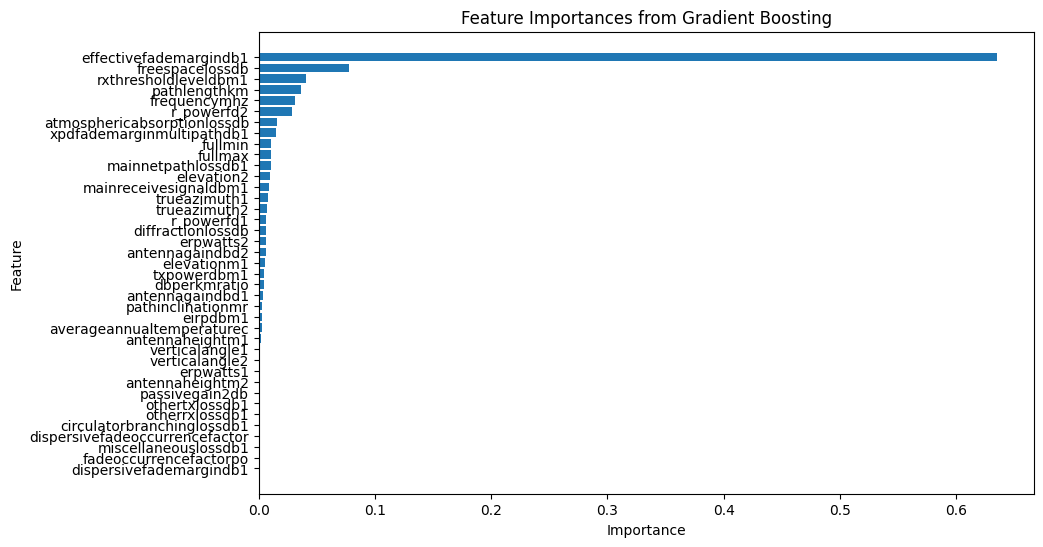

Accuracy with top features: 0.8547215496368039
Classification Report with top features:
              precision    recall  f1-score   support

           1       0.85      0.99      0.91       321
           2       0.92      0.38      0.54        92

    accuracy                           0.85       413
   macro avg       0.88      0.69      0.73       413
weighted avg       0.86      0.85      0.83       413

Confusion Matrix with top features:
[[318   3]
 [ 57  35]]


In [37]:
# Train the model with the best parameters
best_params = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
best_gb_clf = GradientBoostingClassifier(**best_params, random_state=42)
best_gb_clf.fit(X_train, y_train)

# Get feature importances
feature_importances = best_gb_clf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

# Select top N features based on importance
N = 10  # You can change this value based on your requirement
top_features = importance_df['Feature'].head(N)

# Subset the training and testing data to include only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Retrain the Gradient Boosting model with the selected features
best_gb_clf_top = GradientBoostingClassifier(**best_params, random_state=42)
best_gb_clf_top.fit(X_train_top, y_train)

# Predict on the test set with the top features
y_pred_top = best_gb_clf_top.predict(X_test_top)

# Evaluate the model
print("Accuracy with top features:", accuracy_score(y_test, y_pred_top))
print("Classification Report with top features:")
print(classification_report(y_test, y_pred_top))
print("Confusion Matrix with top features:")
print(confusion_matrix(y_test, y_pred_top))

Evaluating under-engineered masts with our optimal model, we adjust the misclassification penalty ratios to 1:h, where h can be 5, 10, or 20, to prioritize accuracy in identifying masts that are under-engineered.

In [57]:
# Weights ratios: false negatives are h times more costly than false positives
ratios = [5, 10, 20]

for h in ratios:
    sample_weights = np.where(y_train == 1, 2, h)  

    # Train the model
    model = GradientBoostingClassifier(random_state=672)
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Predict and evaluate the model
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Display the results
    print(f"Results for cost ratio 1:{h}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}\n")

Results for cost ratio 1:5
Confusion Matrix:
[[298  23]
 [ 43  49]]
Accuracy: 0.8401937046004843, Precision: 0.873900293255132, Recall: 0.9283489096573209, F1 Score: 0.9003021148036254

Results for cost ratio 1:10
Confusion Matrix:
[[272  49]
 [ 38  54]]
Accuracy: 0.7893462469733656, Precision: 0.8774193548387097, Recall: 0.8473520249221184, F1 Score: 0.8621236133122028

Results for cost ratio 1:20
Confusion Matrix:
[[204 117]
 [ 27  65]]
Accuracy: 0.6513317191283293, Precision: 0.8831168831168831, Recall: 0.6355140186915887, F1 Score: 0.7391304347826086



In [60]:
print("Training dataset columns:", training_data_encoded.columns.tolist())
print("Scoring dataset columns:", scoring_data_aligned.columns.tolist())

Training dataset columns: ['eng_class', 'antennagaindbd1', 'antennagaindbd2', 'antennaheightm1', 'antennaheightm2', 'atmosphericabsorptionlossdb', 'averageannualtemperaturec', 'circulatorbranchinglossdb1', 'dbperkmratio', 'diffractionlossdb', 'dispersivefademargindb1', 'dispersivefadeoccurrencefactor', 'effectivefademargindb1', 'eirpdbm1', 'elevation2', 'elevationm1', 'erpwatts1', 'erpwatts2', 'fadeoccurrencefactorpo', 'freespacelossdb', 'frequencymhz', 'mainnetpathlossdb1', 'mainreceivesignaldbm1', 'miscellaneouslossdb1', 'otherrxlossdb1', 'othertxlossdb1', 'passivegain2db', 'pathinclinationmr', 'pathlengthkm', 'rxthresholdleveldbm1', 'r_powerfd1', 'r_powerfd2', 'trueazimuth1', 'trueazimuth2', 'txpowerdbm1', 'verticalangle1', 'verticalangle2', 'xpdfademarginmultipathdb1', 'fullmax', 'fullmin']
Scoring dataset columns: ['antennagaindbd1', 'antennagaindbd2', 'antennaheightm1', 'antennaheightm2', 'atmosphericabsorptionlossdb', 'averageannualtemperaturec', 'circulatorbranchinglossdb1', 'd

final preparation of scoring data to reoder the columns to match training.

In [61]:
if not all(column in scoring_data_aligned.columns for column in X.columns):
    missing_cols = set(X.columns) - set(scoring_data_aligned.columns)
    raise ValueError("The scoring data missing columns: {}".format(missing_cols))

# Reorder the columns of RF_scoringData_encoded to match the order of X
scoring_data_aligned = scoring_data_aligned[X.columns]

Predicting the scoring dataset using the best model of training data.

In [62]:
# Train the model with the best parameters
best_params = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
best_gb_clf = GradientBoostingClassifier(**best_params, random_state=672)
best_gb_clf.fit(X, y)

# Predict the class labels for the scoring dataset
scoring_predictions = best_gb_clf.predict(scoring_data_aligned)

# Add predictions to the scoring dataset
scoring_data_aligned['Predicted_Eng_Class'] = scoring_predictions

# Map the predictions to human-readable labels (assuming 1 = okay, 2 = under engineered)
scoring_data_aligned['Predicted_Eng_Class_Label'] = scoring_data_aligned['Predicted_Eng_Class'].map({1: 'okay', 2: 'under engineered'})


In [65]:
print(scoring_data_aligned['Predicted_Eng_Class_Label'])

0                  okay
1      under engineered
             ...       
934                okay
935                okay
Name: Predicted_Eng_Class_Label, Length: 936, dtype: object


to count the number of okay and under class of the predicted column.

In [66]:
# Print the count of each class in the Predicted_Eng_Class_Label column
class_counts = scoring_data_aligned['Predicted_Eng_Class_Label'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 Predicted_Eng_Class_Label
okay                862
under engineered     74
Name: count, dtype: int64
